Using the other object as test set 🤪

In [139]:
# Bonus cell for using the different test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2
import time
from joblib import dump, load
# Två delar:
# 1: fixa segmentstorleken
# 2: fixa masker för varje segment
# Eller egentligen, skit i det. Applicera masken i förväg?


def getTestObjects(porositythreshold=0.5):
    
    start_time = time.time()
    # _, layer, _, _ = np.shape(oldLayers)
    objectwidth = 100
    objectheight = 100
    xspacing = 116
    yspacing = 300
    xstart = 293
    ystart = 445
    xend = 1730
    yend = 1770
    powderthickness = 80
    endlayer = 225
    vsegments = [0, 150, 187, endlayer]

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths][0:endlayer]
    paths_sorted.sort()
    integrals = np.array([plt.imread(path) for path in paths_sorted])
    # integrals = np.load('integrals.npy')
    t1 = time.time()

    # print("Reading time was: ", (t1 - start_time))
    # np.save('integrals.npy', integrals)
    # t11 = time.time()
    # print("Saving time was: ", (t11 - t1))
    # integrals = np.load('integrals.npy')
    # t12 = time.time()
    # print("Loading time was: ", (t12 - t11))

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])

    objects = np.full((len(coorddf), endlayer, objectheight, objectwidth), np.nan)

    for index, object in coorddf.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

    rtn = np.full(objects.shape, np.nan)
    aggregate = np.sum(objects, axis=(0))

    emptyRatio = 30
    limit = np.percentile(aggregate, emptyRatio)
    testmask = aggregate >= limit
    for object in objects:
        object[~testmask] = np.nan

    filename = f"models/B/mask.joblib"
    dump(testmask, filename) 
    
    t2 = time.time()
    # print("Mask time was: ", (t2 - t1))

    # Create the good frame
    segmentdf = pd.read_csv('Segments2.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity"])
    segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    # segmentdf.drop(segmentdf[(segmentdf.VED > 50)].index, inplace=True)
    segmentdf.reset_index(drop=True, inplace=True)
    vs = [[vsegments[j], vsegments[j+1]] for i in range(0, len(objects)) for j in reversed(range(0, len(vsegments)-1))]
    coorddf = pd.DataFrame(vs, columns=['zstart', 'zend'])
    testobjectinfo = coorddf.join(segmentdf)
    testobjectinfo.drop(testobjectinfo[(testobjectinfo.Objectnumber == 28) | (testobjectinfo.Objectnumber == 21) ].index, inplace=True)
    testobjectinfo.reset_index(drop=True, inplace=True)

    t3 = time.time()
    # print("Dftime was: ", (t3 - t2))

    testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend] for index, object in testobjectinfo.iterrows()]

    del objects
    del coorddf
    del objectCoordinates
    # del paths_sorted
    del integrals
    t4 = time.time()
    # print("objectsplittime was: ", (t4 - t3))
    # print("Totaltime was: ", (t4 - start_time))
    return testobjects, testobjectinfo


In [140]:
# Read train data
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2
from joblib import dump, load

def getTrainObjects(objectsplit=1, upsamplingratio=1, positive_multiplier=1, porositythreshold=0.5, separate_test=True):
    emptyRatio = 47
    objectwidth = 83
    objectheight = 122
    xspacing = 133
    yspacing = 270
    xstart = 293
    ystart = 268
    xend = 1730
    yend = 1770
    hsegments = [0,26,50,74,98,122]
    powderthickness = 80
    endlayer = 187

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths][0:endlayer]
    paths_sorted.sort()
    integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])
    # integrals = np.load('integrals.npy')[0:endlayer]

    # del paths_sorted
    objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    objectinfo = coorddf.join(objectinfo)

    objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

    for index, object in objectinfo.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

    aggregate = np.sum(objects, axis=(0,1))

    emptyRatio = 47
    limit = np.percentile(aggregate, emptyRatio)
    mask = aggregate >= limit
    mask = np.repeat([mask], endlayer, 0)

    filename = f"models/A/mask.joblib"
    dump(mask, filename) 

    for object in objects:
        object[~mask] = np.nan

    # Time to construct the "real" dataframe

    segmentdf = pd.read_csv('Segments.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity", "Area"])
    segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    originalframe = segmentdf.copy()
    hs = [[hsegments[j], hsegments[j+1]] for i in range(0, len(objects)) for j in range(0, len(hsegments)-1)]
    coorddf = pd.DataFrame(hs, columns=['hstart', 'hend'])
    segmentdf = coorddf.join(segmentdf)

    # Start of object multiplication 
    layersPerObject = endlayer // objectsplit
    testEnd = endlayer if separate_test else endlayer - layersPerObject * (objectsplit // 3)
    zs = [segmentdf.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject+1, layersPerObject//(upsamplingratio * positive_multiplier))]
    # testzs = [segmentdf.copy().assign(zstart=testEnd, zend=endlayer)]
    trainobjectinfo = pd.concat(zs, ignore_index=True)
    trainobjectinfo.drop(trainobjectinfo[(trainobjectinfo.Objectnumber == 28) | (trainobjectinfo.Objectnumber == 21) ].index, inplace=True)
    trainobjectinfo.reset_index(drop=True, inplace=True)
    # testobjectinfo = pd.concat(testzs, ignore_index=True)
    # testobjectinfo.drop(testobjectinfo[(testobjectinfo.Objectnumber == 28) | (testobjectinfo.Objectnumber == 21) ].index, inplace=True)
    # testobjectinfo.reset_index(drop=True, inplace=True)

    # Removes extra rows 
    trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]

    trainobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in trainobjectinfo.iterrows()]
    # testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in testobjectinfo.iterrows()]

    # print("fetching data with objectsplit: {}, upsamplingratio: {}, positive_multiplier: {}, porositythreshold: {}".format(objectsplit, upsamplingratio, positive_multiplier, porositythreshold))
    return trainobjects, trainobjectinfo

# assert(np.average(np.isfinite(trainobjects)) == 1)
# assert(np.average(np.isfinite(testobjects)) == 1)
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [141]:
getTestObjects()
getTrainObjects()

([array([[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
  
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
  
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
  
         ...,
  
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., na

In [128]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import tree
import warnings

def preprocess(objects, type, sharpening):
    rtn = []
    # print(rtn.shape)
    for index, object in enumerate(objects):
        object = np.copy(object)
        sharpened = object
        if(sharpening != 'none'):
            sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
            sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
        # Sharpening is done
        if type == 'scatter' or type == 'spatstat':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            rtn.append(xs)
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            avg = np.nanmean(xs)
            stddev = np.nanstd(xs)
            xs = (xs - avg) / avg
            rtn.append(xs)
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    # c, z, y, x = objects.shape


    outlierValues = []
    index = 0
    # return objects
    for object in objects:
        object = np.copy(object)
        z, y, x = object.shape
        # Step 1: calculate neighbourhood
        neighbourkernel = np.ones((neighbourhoodSetting, neighbourhoodSetting)) / neighbourhoodSetting**2
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1

        ys = neighbourhoodValues[0:z-windowSize+1]
        xs = object[offset:z-endoffset]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

        # plt.imshow(xs[0])
        # plt.figure()
        # plt.imshow(xs[0])
        # plt.figure()
        # if(index == 58):
        #     plt.imshow(xs[0])
        #     plt.figure()
        #     plt.imshow(ys[0])
        #     plt.figure()
        #     plt.imshow(filter[0])
        #     plt.figure()
        #     print(len(np.unique(filter)))
        numberOfFilterValues = len(np.unique(filter))
        # print("filterlength is: ", numberOfFilterValues)
        # print("index is:", index)
        assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
        if type == 'spatstat':
            outliers = xs - ys
            avg = np.mean(outliers[filter])
            std = np.std(outliers[filter])
            outliers = (outliers - avg) / std
            outlierValues.append(outliers)
        else:
            with warnings.catch_warnings():
                line = np.polyfit(xs[filter].flatten(), ys[filter].flatten(), 1)
                p = np.poly1d(line)
                outlierValues.append(p(xs) - ys)
            assert(xs.shape == p(ys).shape)
        assert(len(np.unique(outlierValues[index])) > 1)
        assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
        index+=1
    return outlierValues

def encode(outlierobjects, buckets, minval=0, maxval=0):
    numberOfObjects = len(outlierobjects)
    X = np.full((numberOfObjects, buckets), np.nan)
    raw = np.concatenate([oo.flatten() for oo in outlierobjects])
    filter = np.isfinite(raw)
    minval = np.min(raw[filter]) if minval == 0 else minval
    maxval = np.max(raw[filter]) if maxval == 0 else maxval
    for index in range(0, numberOfObjects):
        xs = outlierobjects[index]
        filter = np.isfinite(xs)
        hist, edges = np.histogram(xs[filter], bins=buckets, range=(minval, maxval), density=True)
        X[index] = np.array(hist)
    
    return X, minval, maxval, edges

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, classifier):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1) if classifier == 'KNN' else tree.DecisionTreeClassifier(max_depth=n_neighbors*2, class_weight='balanced', random_state=42)
    clf2 = clf
    scaler = StandardScaler()
    clf = Pipeline([('scaler', scaler), ('classifier', clf)])
    # splits = [(np.arange(0,130,1), np.arange(130,260,1)), (np.arange(130,260,1), np.arange(0,130,1))]
    cvs = cross_val_score(clf, Xtrain, Ytrain, cv=10, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict_proba(Xtest)[:,1]

    return cvs.mean(), metrics.roc_auc_score(Ytest, yfit), clf

In [129]:
from sklearn import metrics
from joblib import dump, load
# Now to tie it all together...

def getPodAndRoc (folder, Xtrain, Ytrain, Xtest, Ytest, classifier, type, z, xy, bins, hyperparameter):
    sharpSetting = 'none'

    trainpreprocessed =preprocess(Xtrain, type, sharpSetting)
    testpreprocessed =preprocess(Xtest, type, sharpSetting)

    trainoutliers = calculateoutliers(trainpreprocessed, type, xy, z)
    testoutliers = calculateoutliers(testpreprocessed, type, xy, z)

    Xtrain, minval, maxval, edges = encode(trainoutliers, bins)
    Xtest, _, _, _ = encode(testoutliers, bins, minval=minval, maxval=maxval)

    # Print in the classify function, can't do it outside? 
    # Xtrain, Ytrain, Xtest, Ytest, n_neighbors, classifier
    Ypred, Yprobs, clf = classify(Xtrain, Ytrain, Xtest, Ytest, hyperparameter, classifier,)

    filename = f"models/{folder}/{classifier}_{type}_{z}_{xy}_{bins}_{hyperparameter}.joblib"
    dump(clf, filename) 
    
    # limits = np.logspace(-1, 1, num=20)
    # limits = np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2])

    # recall = [metrics.recall_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
    # precision = [metrics.precision_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
    
    return Ypred, Yprobs

In [130]:
def justPredict (folder, Xtest, classifier, type, z, xy, bins, hyperparameter):
    sharpSetting = 'none'

    testpreprocessed =preprocess(Xtest, type, sharpSetting)

    testoutliers = calculateoutliers(testpreprocessed, type, xy, z)

    Xtest, _, _, _ = encode(testoutliers, bins)

    # Print in the classify function, can't do it outside? 
    # Xtrain, Ytrain, Xtest, Ytest, n_neighbors, classifier
    # Ypred, Yprobs, clf = classify(Xtrain, Ytrain, Xtest, Ytest, hyperparameter, classifier,)
    clf = load(f"models/{folder}/{classifier}_{type}_{z}_{xy}_{bins}_{hyperparameter}.joblib")
    Ypred = clf.predict(Xtest)
    
    return Ypred

In [131]:
# # Now to tie it all together...
# def doStuff (outputfile, trainobjects, Ytrain, testobjects, Ytest, classifier):
#     columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'cv-auc', 'test-auc',]
#     results = pd.DataFrame(columns=columns)
#     for type in types:
#         for sharpSetting in sharpening:
#             trainpreprocessed =preprocess(trainobjects, type, sharpSetting)
#             testpreprocessed =preprocess(testobjects, type, sharpSetting)
#             for windowsize in windowsizes:
#                 for nSetting in neighbourhoodsize:
#                     trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
#                     testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
#                     for histnorm in histnormalise:
#                         for bincount in bins:
#                             Xtrain, minval, maxval, edges = encode(trainoutliers, bincount)
#                             Xtest, _, _, _ = encode(testoutliers, bincount, minval=minval, maxval=maxval)
#                             for n_neighbors in k:
#                                 cvscore, score = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, histnorm, classifier)
#                                 nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bincount, histnorm, n_neighbors, cvscore, score]], columns=columns)
#                                 results = pd.concat([results, nextRow])
#                             results.to_csv(outputfile, index=False, header=True)

In [114]:
# Training cell B

settingcolumns = ['threshold', 'classifier', 'type', 'z', 'xy', 'bins', 'hyperparameter']
bsettings =  pd.DataFrame([
    [0.1,'KNN','moran',1,7,20,5,],
    [0.1,'KNN','moran',1,5,20,11,],
    [0.1,'KNN','spatstat',1,5,5,5,],
    [0.25,'KNN','moran',1,7,40,7,],
    [0.25,'KNN','moran',1,5,40,11,],
    [0.25,'KNN','moran',1,3,10,7,],
    [0.5,'KNN','spatstat',1,7,40,11,],
    [0.5,'KNN','moran',1,7,40,7,],
    [0.5,'KNN','moran',1,5,40,11,],
], columns=settingcolumns)
asettings =  pd.DataFrame([
    [0.1,'KNN','moran',1,7,20,5,],
    [0.1,'KNN','moran',1,5,40,5,],
    [0.1,'KNN','scatter',1,5,40,5,],
    [0.25,'KNN','scatter',3,5,40,5,],
    [0.25,'KNN','scatter',1,7,10,7,],
    [0.25,'KNN','scatter',1,3,20,5,],
    [0.5,'KNN','scatter',1,3,20,5,],
    [0.5,'KNN','moran',1,7,40,11,],
    [0.5,'DT','scatter',1,7,40,11,],
], columns=settingcolumns)
# trainobjects, trainobjectinfo = getTrainObjects(porositythreshold=0.5, separate_test=True)
# testobjects, testobjectinfo = getTestObjects(porositythreshold=0.5)
# Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
# Ytest = np.array(testobjectinfo.loc[:,"Label"])
# scoresMap = {}
    
# for threshold in [0.1, 0.25, 0.5]:
#     Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
#     porosity = np.array(trainobjectinfo.loc[:,"Porosity"])
#     Xtrain, Xtest, Ytrain, Ytestporosity = train_test_split(trainobjects, porosity, test_size=0.33, random_state=42)
#     Ytest = np.where(Ytestporosity > threshold, 1, 0)
#     Ytrain = np.where(Ytrain > threshold, 1, 0)
#     scoresMap = {}
#     for index, object in asettings[asettings.threshold == threshold].iterrows():
#         Ypred, Yprobs = getPodAndRoc('A', Xtrain, Ytrain, Xtest, Ytest, object.classifier, object.type, object.z, object.xy, object.bins, object.hyperparameter)

#     for index, object in bsettings[asettings.threshold == threshold].iterrows():
#         Ypred, Yprobs = getPodAndRoc('B', trainobjects, np.where(porosity > threshold, 1, 0), testobjects, np.where(np.array(testobjectinfo.loc[:,"Porosity"]) > threshold, 1, 0), object.classifier, object.type, object.z, object.xy, object.bins, object.hyperparameter)
    

fetching data with objectsplit: 1, upsamplingratio: 1, positive_multiplier: 1, porositythreshold: 0.5


In [145]:
# Let's make some timing
import time
times = []
for _, setting in asettings.iterrows():
    for i in range(0, 5):
        start = time.time()
        trainobjects, _, = getTrainObjects(porositythreshold=setting.threshold)
        pred = justPredict ('A', trainobjects, setting.classifier, setting.type, setting.z, setting.xy, setting.bins, setting.hyperparameter)
        times.append(time.time() - start)
for _, setting in bsettings.iterrows():
    for i in range(0, 5):
        start = time.time()
        testobjects, _, = getTestObjects(porositythreshold=setting.threshold)
        pred = justPredict ('B', testobjects, setting.classifier, setting.type, setting.z, setting.xy, setting.bins, setting.hyperparameter)
        times.append(time.time() - start)
# print(np.mean(times))
# print(np.min(times))
# print(np.max(times))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
10.967184436321258
6.258257150650024
19.288974046707153


In [1]:
np.save("times-slow.npy", np.array(times))

NameError: name 'np' is not defined

(array([31., 76., 29., 12., 10.,  3.,  5.,  3.,  6.,  5.,  4.,  5.,  9.,
        20., 18., 11., 14., 11.,  3.,  7., 13.,  9.,  5.,  5.,  5.,  8.,
        18.,  7.,  5.,  3.]),
 array([ 6.25825715,  6.69261438,  7.12697161,  7.56132884,  7.99568607,
         8.4300433 ,  8.86440053,  9.29875776,  9.73311499, 10.16747222,
        10.60182945, 11.03618668, 11.47054391, 11.90490114, 12.33925837,
        12.7736156 , 13.20797283, 13.64233006, 14.07668729, 14.51104452,
        14.94540175, 15.37975898, 15.81411621, 16.24847344, 16.68283067,
        17.1171879 , 17.55154513, 17.98590236, 18.42025959, 18.85461682,
        19.28897405]),
 <BarContainer object of 30 artists>)

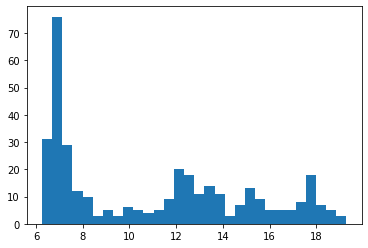

In [147]:
plt.hist(times, bins=30)

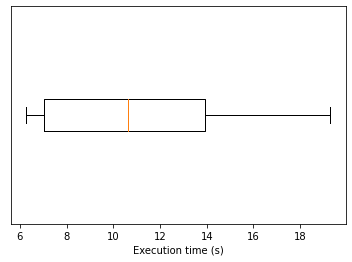

In [155]:
plt.boxplot(times, vert=False, whis=(0, 100))
plt.xlabel("Execution time (s)")
plt.yticks([])
plt.savefig("figures/exectime.pdf", dpi=300)

11.241649482647578
10.765695522228876
10.894208304087321
1348.9979379177094
1291.8834626674652
1307.3049964904785
3948.186397075653


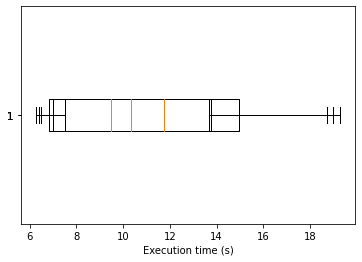

In [15]:
from cProfile import label
import numpy as np
import matplotlib.pyplot as plt
times = np.load('times-slow.npy')
np.mean(times)

# t05 = times[0:3, 9:12, 18:21, 27:30, 36:39, 45:48, 54:57, 63:66, 72:75]

atimes = times[np.mod(np.arange(0, len(times)), 9) < 3]

t025 = times[(np.mod(np.arange(0, len(times)), 9) >= 3) & (np.mod(np.arange(0, len(times)), 9) < 6)]

t05 = times[np.mod(np.arange(0, len(times)), 9) >= 6]

# 1,2,3,10,11,12,19,20,21

# 4,5,6,13,14,15,22,23,24

# 7,8,9,16,17,18,25,26,27
plt.boxplot(times, vert=False, whis=(0, 100))
plt.xlabel("Execution time (s)")
plt.yticks([])
plt.savefig("figures/exectime.pdf", dpi=300)


print(np.mean(t01))
print(np.mean(t025))
print(np.mean(t05))
print(np.sum(t01))
print(np.sum(t025))
print(np.sum(t05))
print(np.sum(times))

plt.boxplot(t05, vert=False, whis=(0, 100))
plt.boxplot(t025, vert=False, whis=(0, 100))
plt.boxplot(t01, vert=False, whis=(0, 100))
# plt.yticks([1,2,3],['0.5', '0.25', '0.1'])
plt.xlabel("Execution time (s)")
plt.savefig("figures/exectime.pdf", dpi=300)

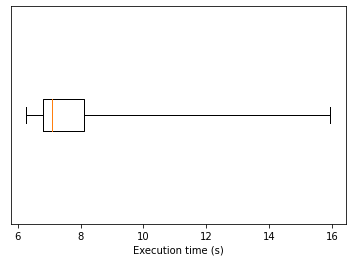

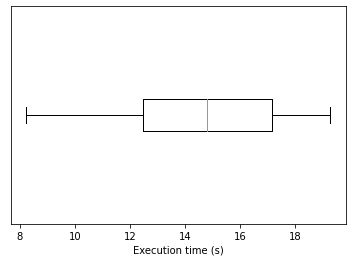

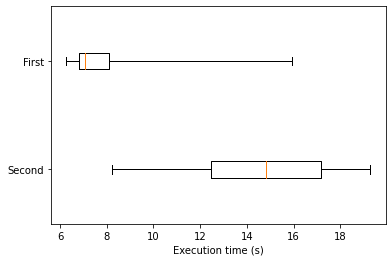

In [22]:
from cProfile import label
import numpy as np
import matplotlib.pyplot as plt
times = np.load('times-slow.npy')
np.mean(times)

atimes = times[np.mod(np.arange(0, len(times)), 18) < 10]
btimes = times[np.mod(np.arange(0, len(times)), 18) >= 10]

plt.boxplot(atimes, vert=False, whis=(0, 100))
plt.xlabel("Execution time (s)")
plt.yticks([])
plt.savefig("figures/aexectime.pdf", dpi=300)
plt.figure()

plt.boxplot(btimes, vert=False, whis=(0, 100))
plt.xlabel("Execution time (s)")
plt.yticks([])
plt.savefig("figures/bexectime.pdf", dpi=300)
plt.figure()
plt.boxplot([btimes, atimes], vert=False, whis=(0, 100))
plt.yticks([2,1],['First', 'Second'])
plt.xlabel("Execution time (s)")
# plt.yticks([])
plt.savefig("figures/abexectime.pdf", dpi=300)


# t025 = times[(np.mod(np.arange(0, len(times)), 9) >= 3) & (np.mod(np.arange(0, len(times)), 9) < 6)]

# t05 = times[np.mod(np.arange(0, len(times)), 9) >= 6]

# 1,2,3,10,11,12,19,20,21

# 4,5,6,13,14,15,22,23,24

# 7,8,9,16,17,18,25,26,27



# print(np.mean(t01))
# print(np.mean(t025))
# print(np.mean(t05))
# print(np.sum(t01))
# print(np.sum(t025))
# print(np.sum(t05))
# print(np.sum(times))

# plt.boxplot(t05, vert=False, whis=(0, 100))
# plt.boxplot(t025, vert=False, whis=(0, 100))
# plt.boxplot(t01, vert=False, whis=(0, 100))
# # plt.yticks([1,2,3],['0.5', '0.25', '0.1'])
# plt.xlabel("Execution time (s)")
# plt.savefig("figures/exectime.pdf", dpi=300)